In [1]:
#####################################################################################################################
#  MNIST Handwritten Digit Reconstruction using Denoising Autoencoder
#  Jesper S. Bajwa
#####################################################################################################################

# Import statements
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Get Dataset
# x_train and x_val are in the form of 28x28 tuples with y_train and y_val being single scalars representing
#  the numbers in the 28x28 images
(x_train, y_train), (x_val, y_val) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# Flattening Function for Dataset
def flatten_data(input_dataset):
  flattened_dataset = np.zeros(shape=(len(input_dataset),784),dtype='float64')
  single_image=np.zeros(shape=(784),dtype='float64')

  for i in range(len(input_dataset)):
    single_image = input_dataset[i].flatten()
    flattened_dataset[i] = single_image

  return flattened_dataset

In [4]:
# Flattening Datasets
x_train = flatten_data(x_train)
x_val = flatten_data(x_val)

print(x_train.shape)
print(x_val.shape)

(60000, 784)
(10000, 784)


In [5]:
# Creating Noised Datasets
x_train_noised = x_train + 15*np.random.normal(0,1, size = x_train.shape)
x_val_noised = x_val + 15*np.random.normal(0,1, size = x_val.shape)

x_train_noised = x_train_noised/255.0
x_val_noised = x_val_noised/255.0

#x_train_noised = np.clip(x_train_noised,0,1)
#x_val_noised = np.clip(x_val_noised,0,1)

In [6]:
# Scaling datasets from 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))

for i in range(len(x_train)):
  x_train[i] = np.reshape(scaler.fit_transform(np.reshape(x_train[i],(-1,1))),(784))

for i in range(len(x_val)):
  x_val[i] = np.reshape(scaler.fit_transform(np.reshape(x_val[i],(-1,1))),(784))

for i in range(len(x_train_noised)):
  x_train_noised[i] = np.reshape(scaler.fit_transform(np.reshape(x_train_noised[i],(-1,1))),(784))

for i in range(len(x_val_noised)):
  x_val_noised[i] = np.reshape(scaler.fit_transform(np.reshape(x_val_noised[i],(-1,1))),(784))

In [8]:
# Checking Dataset Dimensions
print(np.max(x_train))
print(np.min(x_train))
print(np.max(x_val))
print(np.min(x_val))

print(x_train.shape)
print(x_val.shape)

print(np.max(x_train_noised))
print(np.min(x_train_noised))
print(np.max(x_val_noised))
print(np.min(x_val_noised))

print(x_train_noised.shape)
print(x_val_noised.shape)

1.0
0.0
1.0
0.0
(60000, 784)
(10000, 784)
1.0000000000000002
0.0
1.0000000000000002
0.0
(60000, 784)
(10000, 784)


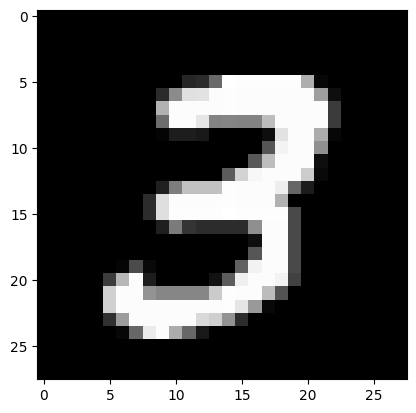

In [9]:
# Visualizing Original Image
plt.imshow(np.reshape(x_train[7],(28,28)), cmap = 'gray')

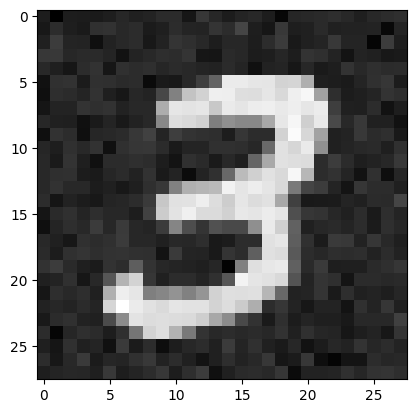

In [10]:
# Visualizing Noised Images
plt.imshow(np.reshape(x_train_noised[7],(28,28)), cmap = 'gray')

In [11]:
# Creating Pre-Trained Network to Map Gaussian Noised Image to Lower Dimension
# Will use this lower dimension as input to manually created decoder layer implementing gradient descent
# Further, this will be used as a benchmark for our model

%%capture

import keras
from keras import layers

# Size of lower-dimensional Representation
encoding_dim = 100

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (100-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

autoencoder.fit(x_train_noised, x_train,
                epochs=30,
                batch_size=500,
                shuffle=True,
                validation_data=(x_val, x_val_noised))

313/313 [==============================] - 0s 1ms/step


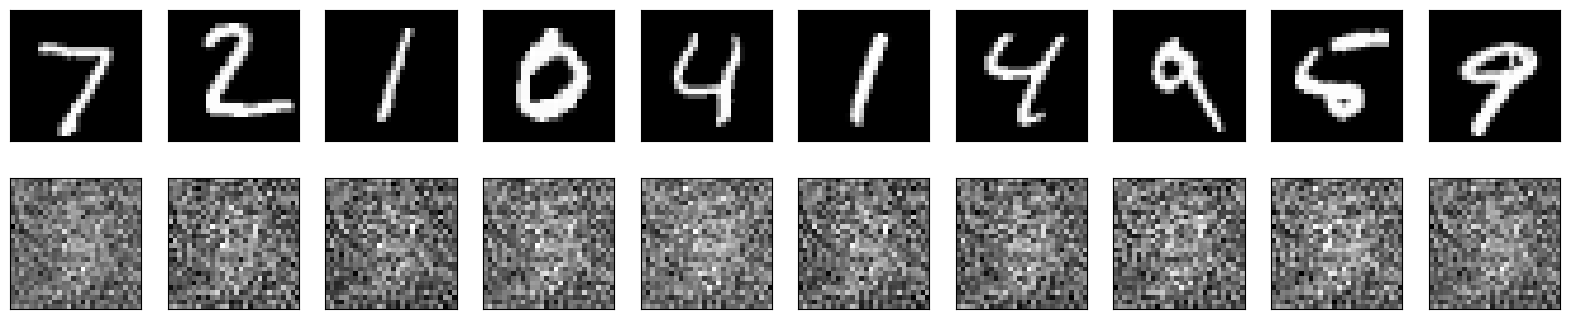

In [12]:
# Encode and decode some digits with Keras model
# Note that we take them from the *val* set
enc_img = encoder.predict(x_val)
decoded_imgs = decoder.predict(enc_img)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
def sigmoid(x):
    ''' Sigmoid function with clipping to prevent dead weights '''

    # clipping
    signal = np.clip(x,-5,5)
    # sigmoid calculation
    signal = 1.0/(1+np.exp(-signal))

    return signal

In [14]:
# Loss function per record (Mean-square error)

def loss_function(desired_response,Xi,theta):
  ''' Loss function (Mean-Sqaured Error) per record '''
  # the loss also contain the L2 regularization term with a lambda of 0.1 (last addition on the right)
  C = (desired_response - sigmoid(np.dot(theta.T, Xi.T)).T)**2 + 0.1*np.sum(np.square(theta))
  return C


In [15]:
def grad_per_record(desired_response,Xi,theta):
  ''' Computes the gradient matrix for each record passed into this function '''

  # initializing the gradient matrix
  grad = np.zeros_like(theta)
  # iterate through each output unit, computing its respective gradient, then assigning it to the gradient matrix
  for unit in range(len(desired_response)):
    grad[:, unit] = grad_per_unit(desired_response[unit], Xi, theta[:,unit])

  return grad


def grad_per_unit(desired, Xi, theta):
  ''' This function computes the derivative w.r.t each output unit iteratively '''

  # dot product of theta tranpose and input stimulus i
  phi = np.matmul(theta.T,Xi)
  # passing phi through the sigmoid activation function
  sig = sigmoid(phi)
  # then computing the derivativ of the sigmoid function w.r.t w (by the chain rule its dsig_dphi * dphi_dw)
  dsig_dw = -sig * (1-sig) * Xi.T
  # finally, this is the last step in the chain rule (dl_dsig * dsig_dw)
  dl_dw = 2 * (desired-sig) * dsig_dw

  return dl_dw

In [16]:
def risk_function(desired_response, record_loss):
  ''' Empirical Risk Function (average loss per record) '''

  ln = 1/(len(desired_response)) * np.sum(record_loss)
  return ln

In [17]:
def d_risk_function(desired_response,dC):
  ''' Empirical Risk Function Derivative with respect to theta
      Note: we are summing the gradients (dC) inside of the gradient descent module '''

  # computing average gradient per desired_response batch
  dln = 1/(len(desired_response)) * dC
  return dln

In [18]:
# defining our batch size
batch_size = 500
# intializing weights, which will be a 100x784 matrix
theta = np.random.normal(0,0.1,(encoding_dim,784))


In [19]:
def gradient_descent(desired_response,Xi,Xval_noised,Xval_desired,weights,learning_rate=0.01, epochs=25, tolerance = 1e-06):
  '''  Gradient Descent with Stopping Criteria '''

  try:
    # get hidden layer output from pretrained Keras model
    encoded_imgs = np.array(encoder.predict(Xi))

    # initialize loss trackers
    loss_history_training = np.zeros(epochs)
    loss_history_val = np.zeros(epochs)

    # run each epoch
    for i in range(epochs):

      batches = desired_response.shape[0]//batch_size  # get number of batches

      # run mini batch
      for j in range(batches):
        print("Batch: ", j+1, "/" , batches, " of epoch: ", i+1)

        # Get mini-batch
        begin = j * batch_size
        end = min(begin + batch_size, x_train.shape[0] - 1)

        desired_response_batch = desired_response[begin:end,:]
        Xi_batch = Xi[begin:end,:]
        encoded_imgs_batch = encoded_imgs[begin:end,:]

        # iterating over the batch, computing the gradient for each input
        dC = 0
        for k,z in enumerate(encoded_imgs_batch):
          # 2*0.1*theta is the derivative of the L2 regularization term, added to the gradient of each batch
          dC += grad_per_record(desired_response_batch[k],z,weights) + 2*0.1*theta

        # stopping criteria
        gradinfinitynorm = np.max(np.absolute(dC))
        if (gradinfinitynorm < tolerance):
          print("Ending training: stopping criterion met.")
          return weights, loss_history_training, loss_history_val

        # gradient descent step
        weights = weights -  learning_rate * d_risk_function(desired_response_batch,dC)

      # track training loss
      tr_sum_loss = loss_function(desired_response,encoded_imgs,weights)
      tr_avg_loss = risk_function(desired_response,tr_sum_loss)
      loss_history_training[i] = tr_avg_loss

      # predict validation
      Xval_encoded = np.array(encoder.predict(Xval_noised))

      val_sum_loss = loss_function(Xval_desired,Xval_encoded,weights)
      val_avg_loss = risk_function(Xval_desired,val_sum_loss)
      loss_history_val[i] = val_avg_loss

      print("Epoch: ", i+1, "Tr Loss: ", tr_avg_loss, "Val Loss: ", val_avg_loss)

  except KeyboardInterrupt:
      print("User interrupted training. [Epoch: ", i+1, "Tr Loss: ", tr_avg_loss, "Val Loss: ", val_avg_loss + "]")
  return weights, loss_history_training, loss_history_val

In [20]:
# an index we are using to get a subset of the dataset
sl = 10000

finalweights, loss_history_training, loss_history_val = gradient_descent(x_train[:sl],x_train_noised[:sl],x_val_noised[:sl],x_val[:sl],theta)

313/313 [==============================] - 1s 2ms/step
Batch:  1 / 20  of epoch:  1
Batch:  2 / 20  of epoch:  1
Batch:  3 / 20  of epoch:  1
Batch:  4 / 20  of epoch:  1
Batch:  5 / 20  of epoch:  1
Batch:  6 / 20  of epoch:  1
Batch:  7 / 20  of epoch:  1
Batch:  8 / 20  of epoch:  1
Batch:  9 / 20  of epoch:  1
Batch:  10 / 20  of epoch:  1
Batch:  11 / 20  of epoch:  1
Batch:  12 / 20  of epoch:  1
Batch:  13 / 20  of epoch:  1
Batch:  14 / 20  of epoch:  1
Batch:  15 / 20  of epoch:  1
Batch:  16 / 20  of epoch:  1
Batch:  17 / 20  of epoch:  1
Batch:  18 / 20  of epoch:  1
Batch:  19 / 20  of epoch:  1
Batch:  20 / 20  of epoch:  1
313/313 [==============================] - 0s 1ms/step
Epoch:  1 Tr Loss:  58097.185342558354 Val Loss:  58096.96477957895
Batch:  1 / 20  of epoch:  2
Batch:  2 / 20  of epoch:  2
Batch:  3 / 20  of epoch:  2
Batch:  4 / 20  of epoch:  2
Batch:  5 / 20  of epoch:  2
Batch:  6 / 20  of epoch:  2
Batch:  7 / 20  of epoch:  2
Batch:  8 / 20  of epoch:  2

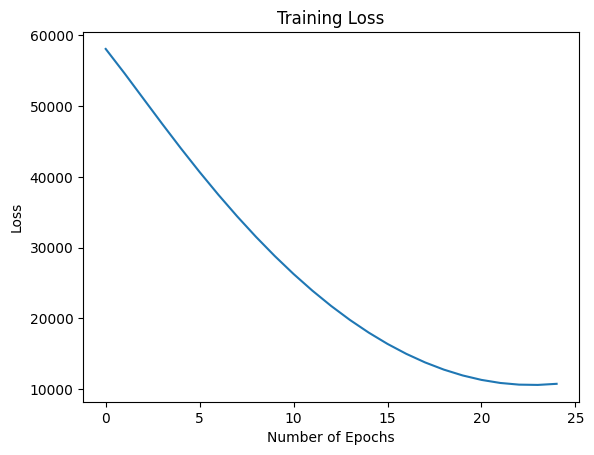

In [21]:
plt.plot(np.arange(len(loss_history_training)),loss_history_training)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

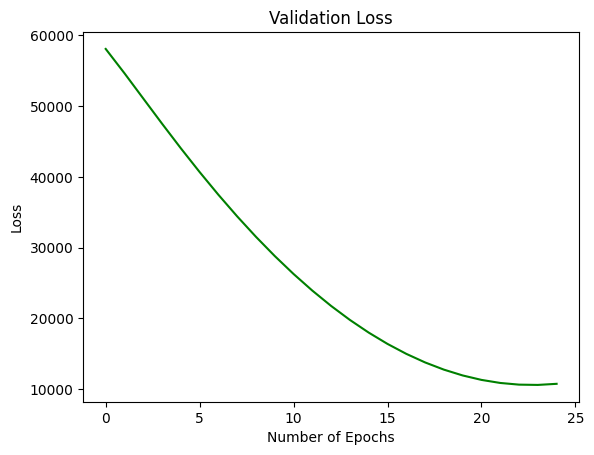

In [22]:
plt.plot(np.arange(len(loss_history_training)),loss_history_val, color='green')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

313/313 [==============================] - 0s 1ms/step


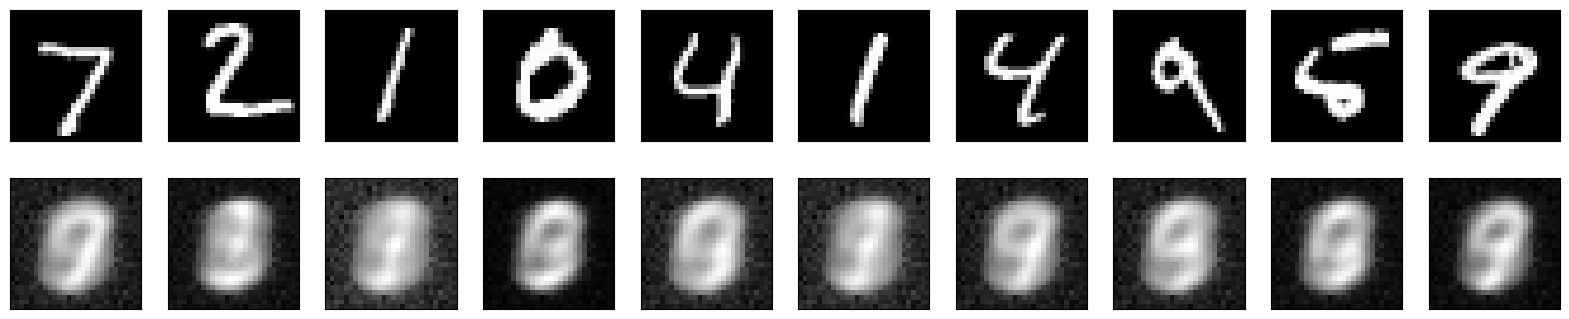

In [23]:
enc_img = encoder.predict(x_val)
decoded_imgs = []
for i in range(10):
  decoded_imgs.append(sigmoid(np.dot(finalweights.T, enc_img[i])))

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()